### We've already determined the WCS solution for two misalgined images in Exercise 1 using `astrometry.net` (`Register_images_exercise.ipynb`). Now we're going to reproject the images onto the same grid.

In [1]:
import numpy as np
import matplotlib
import astropy.io.fits as afits
from astropy.wcs import WCS
import reproject
from astropy.visualization import ZScaleInterval
import astropy.table as at
import astropy.coordinates as coords
import astropy.units as u
from astropy.visualization.wcsaxes import WCSAxes
import astropy.visualization.wcsaxes.frame as frame

%matplotlib notebook
%pylab

Using matplotlib backend: nbAgg
Populating the interactive namespace from numpy and matplotlib


### If you didn't get through Exercise 1, that's OK! I saved my output! You can just use that if you'd like and press on!

In [2]:
!ls ../01_Registration/out/

original_misalignment.pdf           wdd7.080104_0214.1025_6-indx.png
wdd7.040920_0452.051_6-indx.png     wdd7.080104_0214.1025_6-indx.xyls
wdd7.040920_0452.051_6-indx.xyls    wdd7.080104_0214.1025_6-ngc.png
wdd7.040920_0452.051_6-ngc.png      wdd7.080104_0214.1025_6-objs.png
wdd7.040920_0452.051_6-objs.png     wdd7.080104_0214.1025_6.axy
wdd7.040920_0452.051_6.axy          wdd7.080104_0214.1025_6.corr
wdd7.040920_0452.051_6.corr         wdd7.080104_0214.1025_6.match
wdd7.040920_0452.051_6.match        wdd7.080104_0214.1025_6.rdls
wdd7.040920_0452.051_6.rdls         wdd7.080104_0214.1025_6.solved
wdd7.040920_0452.051_6.solved       wdd7.080104_0214.1025_6.solved.fits
wdd7.040920_0452.051_6.solved.fits  wdd7.080104_0214.1025_6.wcs
wdd7.040920_0452.051_6.wcs          wdd7.080104_0214.1025_6.wcs.tan
wdd7.040920_0452.051_6.wcs.tan


### Open the two images and load the wcs solution that you created in the tangent plane (I used `wcs.tan` as my file extension)

In [3]:
# load the two fits images
f1 = afits.open('../01_Registration/out/wdd7.040920_0452.051_6.solved.fits')
f2 = afits.open('../01_Registration/out/wdd7.080104_0214.1025_6.solved.fits')

f1d = f1[0].data
f2d = f2[0].data

# load the two WCS solutions we computed
f1wcs = WCS(afits.Header.fromfile('../01_Registration/out/wdd7.040920_0452.051_6.wcs'))
f2wcs = WCS(afits.Header.fromfile('../01_Registration/out/wdd7.080104_0214.1025_6.wcs'))

### OK, now reproject the data of the 2008 image on to the 2004 image. Look for functions in the `reproject` module. Remember to keep flux conservation in mind!

In [4]:
f2reproj, f2footprint = reproject.reproject_exact((f2d, f2wcs), f1wcs, shape_out=f1d.shape, parallel=True)

### Now display the two images as you did in the last exercise - you should be able to copy and paste the same code even

<IPython.core.display.Javascript object>


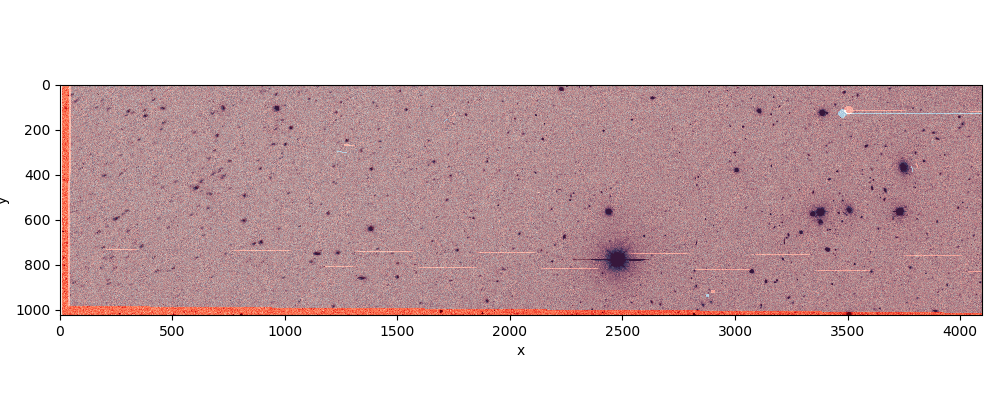

In [5]:
zscaler = ZScaleInterval(nsamples=1000, contrast=0.25)

f1s = zscaler(f1d)
f2s = zscaler(f2reproj)

fig = figure(figsize=(10,4))
ax = fig.add_subplot(1,1,1)
ax.imshow(f1s.T, cmap='Reds')
ax.imshow(f2s.T, cmap='Blues', alpha=0.5)
tight_layout()
xlabel('x')
ylabel('y')
savefig('out/reprojected.pdf')

### Hopefully that's halfway reasonable looking compared to what we started from! For funsies, scale both images to have mean 1 and attempt to subtract them. Remember than there are `NaNs` in the reprojected image!

In [6]:
mask = (f2footprint > 0)
f1m = f1d.mean()
f2m = f2reproj[mask].mean()

### Now construct a simple difference image from the original data

In [7]:
diff = f1d/f1m - f2reproj/f2m
diffs = zscaler(diff)

### Create a figure instance, zscale the differences and see what the residuals look like

<IPython.core.display.Javascript object>


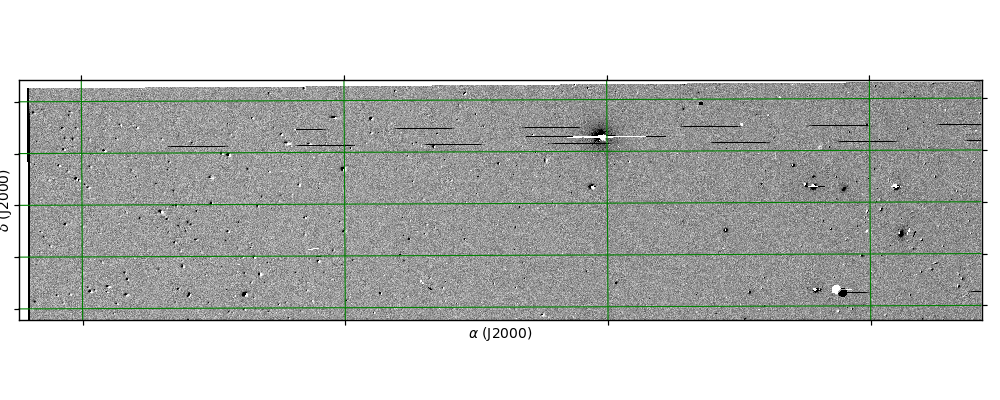

In [8]:
fig2 = figure(figsize=(10,4))
ax2 = fig2.add_subplot(1,1,1, projection=f1wcs)
ax2.imshow(diffs.T, cmap='Greys', origin='lower')

# add a grey grid for what whatever we're using as the native projection
ax2.coords.grid(True, color='green', ls='solid')
ra = ax2.coords['ra']
dec = ax2.coords['dec']

ra.set_axislabel(r'$\alpha$ (J2000)')
dec.set_axislabel(r'$\delta$ (J2000)')
tight_layout()
savefig('out/kinda_difference_image.pdf')

### Our WCS solution wasn't perfect, and the two images are still slightly offset. They're also different filters (one is B band and one is R band), really different depths, have very different PSFs, and we've not masked out CCD artifacts, or bright stars. Still, that's a difference image of a sort! 